In [1]:
import pandas as pd
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
from detoxify import Detoxify
classificator = Detoxify('unbiased')
results = classificator.predict(['example text 1','G...! What the fuck?'])

In [3]:
results['toxicity']

[0.0004102117964066565, 0.974835991859436]

In [4]:
detox_data = pd.read_csv('../data/interim/test_filtered.csv')
X, y_true = detox_data['reference'].values, detox_data['translation'].values

In [5]:
X[:5]

array(["Hot chicks are starfuckers in Coeur d'Alene.",
       "Oh, Grace, don't be ridiculous.", 'Two... - Fuck yo sister.',
       "Next time you decide to take a bath, Private, let me know, or I'll kick your ass,",
       'I finally caught you, you dirty--'], dtype=object)

In [6]:
# import sys
# sys.executable
#!c:\\Users\\hir0\\anaconda3\\python.exe -m pip install git+https://github.com/PrithivirajDamodaran/Parrot_Paraphraser.git
from parrot import Parrot
paraphraser_model = Parrot(model_tag="prithivida/parrot_paraphraser_on_T5", use_gpu=True)

In [8]:
def T5_paraphraser(sentence):

    res = paraphraser_model.augment(input_phrase=sentence, use_gpu=True)
    if res:
        res = list(map(lambda x: x[0], res))
    else:
        res = [sentence]
    return res


In [9]:
#hyperparameter
#n-word tokenizer
def n_word_tokenizer(sentence, n=2):
    splitted = sentence.split()
    slices = [splitted[i * n: i * n + n] for i in range((len(splitted)  + n - 1)// n)]
    n_sentence = [' '.join(part) for part in slices]
    return n_sentence

In [10]:
n_word_tokenizer('ya ebaniy 4ert idi te nahui r', n=2)

['ya ebaniy', '4ert idi', 'te nahui', 'r']

In [11]:
def paraphraser(sentence, n):
    def get_synonym_by_context(sentence):
        # Disambiguate the word in the context sentences
        paraphrased_variants = T5_paraphraser(sentence)
        #rearrange synonyms by they toxicity
        synonyms = sorted([(synonym, classificator.predict(synonym)['toxicity']) for synonym in paraphrased_variants], key= lambda x: x[1])
        return synonyms[0][0]
    splitted_to_n_words = n_word_tokenizer(sentence, n=n)
    best_paraphrased = [get_synonym_by_context(part) for part in splitted_to_n_words]
    return ' '.join(best_paraphrased)


In [12]:
for i in range(10):
    print(f'Original:{X[i]}')
    print(f'Detoxified:{paraphraser(X[i], len(X[i]))}')

Original:Hot chicks are starfuckers in Coeur d'Alene.
Detoxified:Hot chicks are starfuckers in Coeur d'Alene.
Original:Oh, Grace, don't be ridiculous.
Detoxified:Oh, Grace, don't be ridiculous.
Original:Two... - Fuck yo sister.
Detoxified:two - fuck your sister
Original:Next time you decide to take a bath, Private, let me know, or I'll kick your ass,
Detoxified:when you decide to bathe private let me know or i'll kick your hammer
Original:I finally caught you, you dirty--
Detoxified:I finally caught you, you dirty--
Original:God, diarrhoea like thatmust be Anti-Hippocratic.
Detoxified:God, diarrhoea like thatmust be Anti-Hippocratic.
Original:You're a liar. - And I love you for it.
Detoxified:you're a lie
Original:'I don't need to look at that rubbish, I know it all.'
Detoxified:'I don't need to look at that rubbish, I know it all.'
Original:You know You bitch and you complain and you tell me these things.
Detoxified:you know you complain and you tell me all of these things
Original:I'

In [13]:
import sys
sys.path.insert(0, '../src/metric')
from metric import calculate_metric


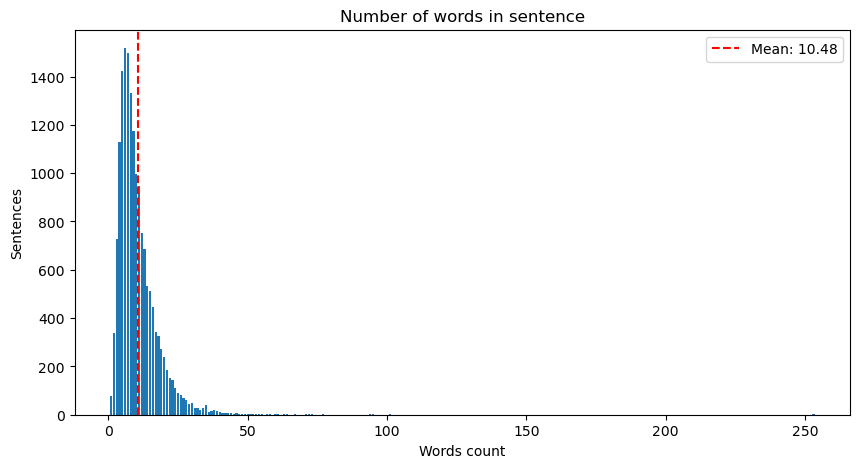

In [39]:
import matplotlib.pyplot as plt
import numpy as np


lens = list(map(lambda x: len(x.split()), X))
unique_lens, cnt = np.unique(lens, return_counts=True)


mean = np.sum(unique_lens * cnt) / np.sum(cnt)

plt.figure(figsize=(10, 5))
plt.bar(unique_lens, cnt)

plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.title('Number of words in sentence')
plt.xlabel('Words count')
plt.ylabel('Sentences')
plt.legend()
plt.show()


In [14]:
#grid search of n
#let's take 100 examples due to lack of perfomance and tring to figure out the best n
N_samples = 100
X_subset, y_true_subset = X[:N_samples], y_true[:N_samples]

Since the number of words in average is 10, so let's grid search n until the half of sentence and take to consideration also the whole sentence

In [15]:
from tqdm import tqdm
max_number_of_words = max(list(map(lambda x: len(x.split()), X_subset)))
print(max_number_of_words)

n_params = [2, 3, 4, 5, max_number_of_words]
dict_metrics = {'ACC': [], 'SIM': [], 'FL': [], 'J': [], 'BLUE':[]}

for ind, n in tqdm(enumerate(n_params)):
    outputs = []
    
    for sentence in X_subset:
        outputs.append(paraphraser(sentence, min(n, len(sentence.split()))))
    
    metrics = calculate_metric(y_true_subset, outputs)
    for key in metrics:
        dict_metrics[key].append(metrics[key])



25


0it [00:00, ?it/s]

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:00<00:00, 19.20it/s]
c:\Users\hir0\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order i

Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 4/4 [00:00<00:00, 126.00it/s]


Calculating CoLA acceptability stats


100%|██████████| 4/4 [00:00<00:00,  8.63it/s]
1it [03:16, 196.74s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.2600|0.7270|0.6900|0.1531|0.4694|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:00<00:00, 16.08it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 4/4 [00:00<00:00, 140.16it/s]


Calculating CoLA acceptability stats


100%|██████████| 4/4 [00:00<00:00,  7.55it/s]
2it [05:56, 174.73s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.2700|0.7262|0.5900|0.1093|0.4792|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:00<00:00, 13.89it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 4/4 [00:00<00:00, 193.80it/s]


Calculating CoLA acceptability stats


100%|██████████| 4/4 [00:00<00:00,  9.07it/s]
3it [08:11, 156.93s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.3500|0.7257|0.6800|0.1924|0.4789|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:00<00:00, 11.50it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 4/4 [00:00<00:00, 145.04it/s]


Calculating CoLA acceptability stats


100%|██████████| 4/4 [00:00<00:00,  7.17it/s]
4it [10:12, 142.65s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.3800|0.7290|0.6700|0.1786|0.4738|

running on cuda
Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 4/4 [00:00<00:00, 12.40it/s]


Calculating BLEU similarity
Calculating similarity by Wieting subword-embedding SIM model


100%|██████████| 4/4 [00:00<00:00, 172.11it/s]


Calculating CoLA acceptability stats


100%|██████████| 4/4 [00:00<00:00,  9.01it/s]
5it [11:26, 137.27s/it]

| ACC | SIM |  FL  |   J   | BLEU |

| --- | --- | ---- |  ---  | ---- |

|0.4900|0.7202|0.5400|0.2281|0.4702|



In [40]:
dict_metrics

{'ACC': [0.26, 0.27, 0.35, 0.38, 0.49],
 'SIM': [0.7269790127873421,
  0.7262186995148658,
  0.7256658336520195,
  0.7289981850981713,
  0.7202394446730613],
 'FL': [0.69, 0.59, 0.68, 0.67, 0.54],
 'J': [0.15314846634864807,
  0.10925602167844772,
  0.1923617935180664,
  0.17864975214004516,
  0.22806155890226365],
 'BLUE': [0.46942134182327655,
  0.47924158708759246,
  0.47891737119426564,
  0.47382208001976617,
  0.4701602405710867]}

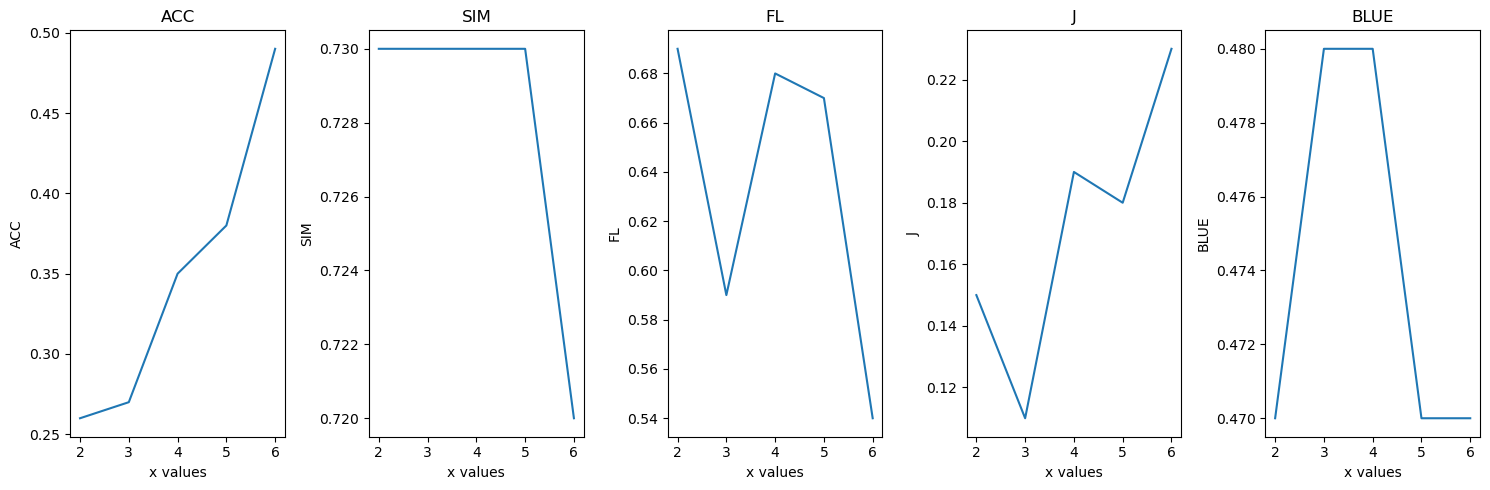

In [53]:
fig, axs = plt.subplots(1, len(dict_metrics), figsize=(15, 5))
x = [2, 3, 4, 5, 6]
#6 - the whole sentence
for i, (metric, values) in enumerate(dict_metrics.items()):
    axs[i].plot(x, np.round(values, 2))
    axs[i].set_title(metric)
    axs[i].set_xlabel('x values')
    axs[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

In [17]:
for i in range(10):
    print(f'Original:{X[i]}')
    print(f'Detoxified:{paraphraser(X[i], 5)}')

Original:Hot chicks are starfuckers in Coeur d'Alene.
Detoxified:Hot chicks are starfuckers in coeur d'alene
Original:Oh, Grace, don't be ridiculous.
Detoxified:Oh, Grace, don't be ridiculous.
Original:Two... - Fuck yo sister.
Detoxified:two - fuck your sister
Original:Next time you decide to take a bath, Private, let me know, or I'll kick your ass,
Detoxified:next time you decide to do it take a bath private let me know your ass,
Original:I finally caught you, you dirty--
Detoxified:i finally found you dirty--
Original:God, diarrhoea like thatmust be Anti-Hippocratic.
Detoxified:God, diarrhoea like thatmust be Anti-Hippocratic.
Original:You're a liar. - And I love you for it.
Detoxified:you're a lie i love you because of that
Original:'I don't need to look at that rubbish, I know it all.'
Detoxified:i don't have to look i know it it all.'
Original:You know You bitch and you complain and you tell me these things.
Detoxified:You know You bitch and you complain and tell someone me these 

In [18]:
# predictions_hypothesis1 = pd.DataFrame({'Predictions': [paraphraser(sentence, best_n) for sentence in X]})
# predictions_hypothesis1.to_csv('../data/interim/hypothesis1_predictions.csv')